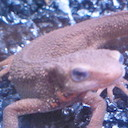

In [1]:
using Images, TestImages

img = load("imori.jpg")

## Q.1. チャネル入れ替え
画像を読み込み、RGBをBGRの順に入れ替えよ。

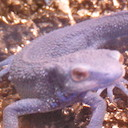

In [2]:
toBGR(rgb) = RGB(rgb.b, rgb.g, rgb.r)
toBGR.(img)

## Q.2. グレースケール化
画像をグレースケールにせよ。 グレースケールとは、画像の輝度表現方法の一種であり下式で計算される。
$$
Y = 0.2126 R + 0.7152 G + 0.0722 B
$$

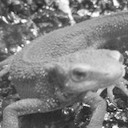

In [3]:
gray(rgb) = Gray(0.2126*rgb.r + 0.7152*rgb.g + 0.0722*rgb.b)
gray.(img)

## Q.3. 二値化
画像を二値化せよ。 二値化とは、画像を黒と白の二値で表現する方法である。 ここでは、グレースケールにおいて閾値を128に設定し、下式で二値化する。
```
y = { 0 (if y < 128)
     255 (else)
```

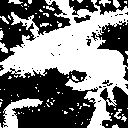

In [4]:
binary(rgb) = gray(rgb) < 128/255 ? Gray(0) : Gray(1)
binary.(img)

## Q.4. 大津の二値化
大津の二値化を実装せよ。 大津の二値化とは判別分析法と呼ばれ、二値化における分離の閾値を自動決定する手法である。 これは**クラス内分散**と**クラス間分散**の比から計算される。

* 閾値 $t$ 未満をクラス $0$, $t$ 以上をクラス $1$ とする。
* $w_0, w_1 ...$ 閾値 $t$ により分離された各クラスの画素数の割合 ($w_0 + w_1 = 1$ を満たす)
* $S_0^2, S_1^2 ...$ 各クラスの画素値の分散
* $M_0, M_1 ...$ 各クラスの画素値の平均値

とすると、

クラス内分散 $$
S^2_w = w_0 S_0^2 + w_1 S_1^2
$$
クラス間分散 $$
\begin{align}
S^2_b &= w_0 (M_0 - M_1)^2 + w_1 (M_1 - M_t)^2 \\
      &= w_0 w_1 (M_0 - M_1)^2
\end{align}
$$
画像全体の画素の分散 $$
S_t^2 = S_w^2 + S_b^2 = (const)
$$
となり、分離度 X は次式で定義される。

分離度 $$
    X = \frac{S_b^2}{S_{in}^2} = \frac{S_b^2}{S^2 - S_b^2}
$$
となるので、$$
argmax_t X = argmax_t S_b^2
$$
となる。

すなわち、$S_b^2 = w_0 w_1 (M_0 - M_1)^2$ が最大となる、閾値$t$を二値化の閾値とすれば良い。

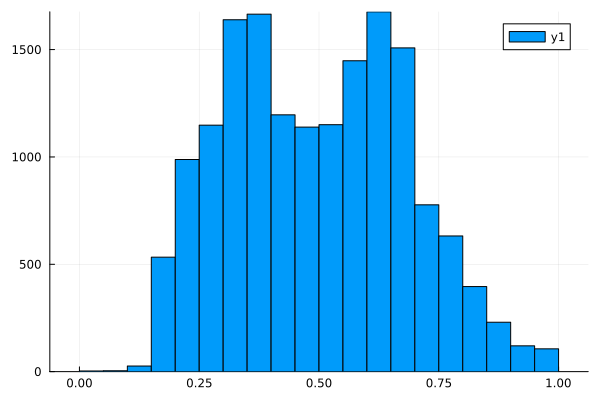

In [5]:
using Plots
histogram(gray.(img) |> g -> getfield.(g, :val) |> vec)

In [6]:
module MyOtsu
import Images: Gray

mean(v) = sum(v) / length(v)
var(v) = begin
    m = mean(v)
    s = 0
    for x in v
        s += (x - m)^2
    end
    s / length(v)
end


function test(img, t)
    V₀ = filter(x -> x > t, img)
    V₁ = filter(x -> x <= t, img)
    w₀, w₁ = length.([V₀, V₁]) / length(img)
    M₀, M₁ = mean.([V₀, V₁])
    #S₀², S₁² = var.([V₀, V₁])
    #S²w = w₀*S₀² + w₁*S₁²
    S²b = w₀*w₁ * (M₀ - M₁)^2
end

gray(c, t) = c > t ? Gray(1) : Gray(0) 

function binary(img)
    max, maxₜ = 0, 0
    for t in 0:0.01:1
        result = test(img, t)
        if result > max
            max, maxₜ = result, t
        end
    end
    @show maxₜ
    gray.(img, maxₜ)
end

end

Main.MyOtsu

maxₜ = 0.5


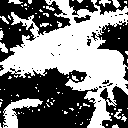

In [7]:
MyOtsu.binary(gray.(img))

## Q.5. HSV変換
HSV変換を実装して、色相Hを反転せよ。
HSV変換とは、Hue(色相)、Saturation(彩度)、Value(明度) で色を表現する手法である。

* Hue ... 色合いを0~360度で表現し、赤や青など色の種類を示す。 ( 0 <= H < 360) 色相は次の色に対応する。
```
赤 黄色  緑  水色  青  紫   赤
0  60  120  180 240 300 360
```
* Saturation ... 色の鮮やかさ。Saturationが低いと灰色さが顕著になり、くすんだ色となる。 ( 0<= S < 1)
* Value ... 色の明るさ。Valueが高いほど白に近く、Valueが低いほど黒に近くなる。 ( 0 <= V < 1)

RGB -> HSV変換は以下の式で定義される。

R,G,Bが$[0,1]$の範囲にあるとする。
```
Max = max(R,G,B)
Min = min(R,G,B)

H =  { 0                            (if Min=Max)
       60 x (G-R) / (Max-Min) + 60  (if Min=B)
       60 x (B-G) / (Max-Min) + 180 (if Min=R)
       60 x (R-B) / (Max-Min) + 300 (if Min=G)
       
V = Max

S = Max - Min
```
HSV -> RGB変換は以下の式で定義される。
```
C = S

H' = H / 60

X = C (1 - |H' mod 2 - 1|)

(R,G,B) = (V - C) (1,1,1) + { (0, 0, 0)  (if H is undefined)
                              (C, X, 0)  (if 0 <= H' < 1)
                              (X, C, 0)  (if 1 <= H' < 2)
                              (0, C, X)  (if 2 <= H' < 3)
                              (0, X, C)  (if 3 <= H' < 4)
                              (X, 0, C)  (if 4 <= H' < 5)
                              (C, 0, X)  (if 5 <= H' < 6)
```
ここでは色相Hを反転(180を加算)し、RGBに直し画像を表示せよ。


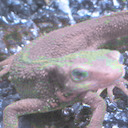

In [24]:
function toHSV(rgb)
    max = [rgb.r, rgb.g, rgb.b] |> maximum
    min = [rgb.r, rgb.g, rgb.b] |> minimum
    H = if min == max
            0
        elseif min == rgb.b
            60(rgb.g - rgb.r) / (max - min) + 60
        elseif min == rgb.r
            60(rgb.b - rgb.g) / (max - min) + 180
        else
            60(rgb.r - rgb.b) / (max - min) + 300
        end
    V = max
    S = max - min
    HSV(H, S, V)
end

toHSV.(img)

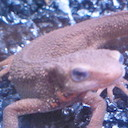

In [9]:
# 微妙に色が変わったので別の公式で算出
# https://zenn.dev/hk_ilohas/articles/rgb-hsv-convert
function toHSV_(rgb)
    R, G, B = [rgb.r, rgb.g, rgb.b] * 255
    max = [R, G, B] |> maximum
    min = [R, G, B] |> minimum
    H = if min == max
            0
        elseif max == R
            60(G - B) / (max - min) 
        elseif max == G
            60(B - R) / (max - min) + 120
        else
            60(R - G) / (max - min) + 240
        end
    V = max / 255
    S = (max - min) / max
    HSV(H, S, V)
end

toHSV_.(img)

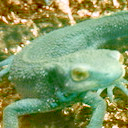

In [10]:
function toRGB(hsv)
    C = hsv.s
    H = hsv.h / 60
    X = C * (1 - abs(H % 2 - 1))
    R, G, B = (hsv.v - C)*[1, 1, 1] + if 0 <= H < 1
            [C, X, 0]
        elseif 1 <= H < 2
            [X, C, 0]
        elseif 2 <= H < 3
            [0, C, X]
        elseif 3 <= H < 4
            [0, X, C]
        elseif 4 <= H < 5
            [X, 0, C]
        elseif 5 <= H < 6
            [C, 0, X]
        else
            [0, 0, 0]
        end
    
    RGB(R, G, B)
end

hsv = toHSV_.(img)
map(x -> HSV((x.h + 180) % 360, x.s, x.v), hsv) .|> toRGB

## Q.6. 減色処理
ここでは画像の値を256^3から4^3、すなわちR,G,B in {32, 96, 160, 224}の各4値に減色せよ。 これは量子化操作である。 各値に関して、以下の様に定義する。
```
val = {  32  (  0 <= val <  64)
         96  ( 64 <= val < 128)
        160  (128 <= val < 192)
        224  (192 <= val < 256)
```

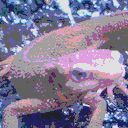

In [11]:
function mysample_value(v)
    if 0 <= v < 64
        32
    elseif 64 <= v < 128
        96
    elseif 128 <= v < 192
        160
    else
        224
    end
end

function mysample(rgb)
    R = (255 * rgb.r |> mysample_value) / 255
    G = (255 * rgb.g |> mysample_value) / 255
    B = (255 * rgb.b |> mysample_value) / 255
    RGB(R, G, B)
end

mysample.(img)

## Q.7. 平均プーリング
ここでは画像をグリッド分割(ある固定長の領域に分ける)し、かく領域内(セル)の平均値でその領域内の値を埋める。 このようにグリッド分割し、その領域内の代表値を求める操作は **Pooling(プーリング)** と呼ばれる。 これらプーリング操作は **CNN(Convolutional Neural Network)** において重要な役割を持つ。

これは次式で定義される。
```
v = 1/|R| * Sum_{i in R} v_i
```
ここではimori.jpgは128x128なので、8x8にグリッド分割し、平均プーリングせよ。

In [12]:
function average(v::Vector{<:Number})
    sum(v) / length(v)
end

function average(colors::Vector{RGB{N0f8}})
    R = map(rgb -> rgb.r, colors) |> average
    G = map(rgb -> rgb.g, colors) |> average
    B = map(rgb -> rgb.b, colors) |> average
    RGB(R, G, B)
end


function average_pooling(img, pool_size = 8)
    h, w = img |> size
    result = zeros(RGB, h, w)
    for i in 1:pool_size:h
        for j in 1:pool_size:w
            range = (i:i+pool_size-1, j:j+pool_size-1)
            result[range...] .= img[range...] |> vec |> average
        end
    end
    result
end

average_pooling (generic function with 2 methods)

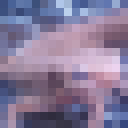

In [13]:
average_pooling(img)

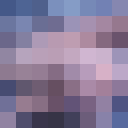

In [14]:
average_pooling(img, 16)

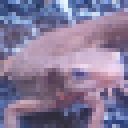

In [15]:
average_pooling(img, 4)

## Q.8. Maxプーリング
ここでは平均値でなく最大値でプーリングせよ。

In [16]:
function Base.maximum(colors::Vector{RGB{N0f8}})
    R = map(rgb -> rgb.r, colors) |> maximum
    G = map(rgb -> rgb.g, colors) |> maximum
    B = map(rgb -> rgb.b, colors) |> maximum
    RGB(R, G, B)
end


function max_pooling(img, pool_size = 8)
    h, w = img |> size
    result = zeros(RGB, h, w)
    for i in 1:pool_size:h
        for j in 1:pool_size:w
            range = (i:i+pool_size-1, j:j+pool_size-1)
            result[range...] .= img[range...] |> vec |> maximum
        end
    end
    result
end

max_pooling (generic function with 2 methods)

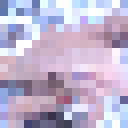

In [18]:
max_pooling(img)

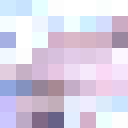

In [20]:
max_pooling(img, 16)

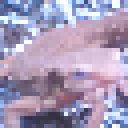

In [19]:
max_pooling(img, 4)

## Q.9. ガウシアンフィルタ
ガウシアンフィルタ(3x3、標準偏差1.3)を実装し、imori_noise.jpgのノイズを除去せよ。

ガウシアンフィルタとは画像の平滑化（滑らかにする）を行うフィルタの一種であり、ノイズ除去にも使われる。

ノイズ除去には他にも、メディアンフィルタ(Q.10)、平滑化フィルタ(Q.11)、LoGフィルタ(Q.19)などがある。

ガウシアンフィルタは注目画素の周辺画素を、ガウス分布による重み付けで平滑化し、次式で定義される。 このような重みはカーネルやフィルタと呼ばれる。

ただし、画像の端はこのままではフィルタリングできないため、画素が足りない部分は0で埋める。これを0パディングと呼ぶ。 かつ、重みは正規化する。(sum g = 1)

重みはガウス分布から次式になる。
$$
    g(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$
```
重み g(x,y,s) = 1/ (2 * pi * sigma * sigma) * exp( - (x^2 + y^2) / (2*s^2))
標準偏差s = 1.3による8近傍ガウシアンフィルタは
            1 2 1
K =  1/16 [ 2 4 2 ]
            1 2 1
```

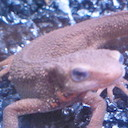

In [29]:
g(x, y, σ) = (1 / 2πσ^2) * exp(-(x^2 + y^2) / 2σ^2)

# TODO
function gaussian(img, σ = 1.3)
    h, w = img |> size
    result = zeros(RGB, h, w)
    for i in 1:h
        for j in 1:w
            result[i, j] = img[i, j]
        end
    end
    result
end

gaussian(img)